In [1]:
%%capture
!rm -rf data/*
!unzip data.zip -d data/
!pip install --no-cache-dir pyldavis
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
%matplotlib inline

# Topic Modeling in Python

In Lisa Rhody's article, "Topic Modeling and Figurative Language", she uses LDA topic modeling to look at ekphrasis poetry. She argues that ekphrasis poetry is particulary well-suited to an LDA analysis because of the assumption of a previously existing set of topics. She's able to extract a number of topics, each constituted of a set of words and probabilities. While we don't have Rhody's corpus, we can use this technique on any large text corpus. We'll use a corpus of novels curated by Andrew Piper.

## Corpus Description
We'll look at an English-language subset of Andrew Piper's novel corpus, totaling 150 novels by British and American authors spanning the years 1771-1930. These texts reside on our volume, each in a separate plaintext file. Metadata is contained in a spreadsheet distributed with the novel files by the [txtLAB](https://txtlab.org/) at McGill.

The metadata provided describes the corpus that exists as `.txt` files. So let's first read in the metadata:

In [2]:
metadata_tb = Table.read_table('data/txtlab_Novel150_English.csv')
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt",151,English,1771,"Mackenzie,Henry",TheManofFeeling,male,first,36458
"EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Nov ...",152,English,1771,"Smollett,Tobias",TheExpedictionofHenryClinker,male,first,148261
"EN_1778_Burney,Fanny_Evelina_Novel.txt",153,English,1778,"Burney,Fanny",Evelina,female,first,154168
"EN_1782_Burney,Fanny_Cecilia_Novel.txt",154,English,1782,"Burney,Fanny",Cecilia,female,third,328981
"EN_1786_Beckford,William_Vathek_Novel.txt",155,English,1786,"Beckford,William",Vathek,male,third,36077


Before we go anywhere, let's randomly shuffle the rows so that we don't have them ordered by dates or anything else:

In [3]:
np.random.seed(0)
metadata_tb = Table.from_df(metadata_tb.to_df().sample(frac=1))
metadata_tb.show(5)

filename,id,language,date,author,title,gender,person,length
"EN_1900_Dreiser,Theodore_SisterCarrie_Novel.txt",265,English,1900,"Dreiser,Theodore",SisterCarrie,male,third,156048
"EN_1853_Stowe,HarrietBeecher_UncleTom'sCabin_Novel.txt",213,English,1853,"Stowe,HarrietBeecher",UncleTom'sCabin,female,third,180498
"EN_1820_Scott,Walter_Ivanhoe_Novel.txt",184,English,1820,"Scott,Walter",Ivanhoe,male,third,175069
"EN_1895_Crane,Stephen_TheRedBadgeofCourage_Novel.txt",258,English,1895,"Crane,Stephen",TheRedBadgeofCourage,male,third,46049
"EN_1794_Godwin,William_CalebWilliams_Novel.txt",158,English,1794,"Godwin,William",CalebWilliams,male,first,143832


We can see the column variables we have with the `.labels` attribute:

In [4]:
metadata_tb.labels

('filename',
 'id',
 'language',
 'date',
 'author',
 'title',
 'gender',
 'person',
 'length')

To clarify:
<ol><li>Filename: Name of file on disk</li>
<li>ID: Unique ID in Piper corpus</li>
<li>Language: Language of novel</li>
<li>Date: Initial publication date</li>
<li>Title: Title of novel</li>
<li>Gender: Authorial gender</li>
<li>Person: Textual perspective</li>
<li>Length: Number of tokens in novel</li></ol>

We see a list of `filename`s in the table, these map into a folder we have called `txtlab_Novel150_English`:

In [5]:
!ls data/txtlab_Novel150_English/

EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt
EN_1771_Smollett,Tobias_TheExpedictionofHenryClinker_Novel.txt
EN_1778_Burney,Fanny_Evelina_Novel.txt
EN_1782_Burney,Fanny_Cecilia_Novel.txt
EN_1786_Beckford,William_Vathek_Novel.txt
EN_1788_Wollstonecraft,Mary_Mary_Novel.txt
EN_1790_Radcliffe,Ann_ASicilianRomance_Novel.txt
EN_1794_Godwin,William_CalebWilliams_Novel.txt
EN_1794_Radcliffe,Ann_TheMysteriesofUdolpho_Novel.txt
EN_1794_Rowson,Susanna_CharlotteTemple_Novel.txt
EN_1795_Lewis,Matthew_TheMonk_Novel.txt
EN_1796_Bonhote,Elizabeth_BungayCastle_Novel.txt
EN_1796_Burney,Fanny_Camilla_Novel.txt
EN_1796_Hays,Mary_EmmaCourtney_Novel.txt
EN_1797_Foster,HannahWebster_TheCoquette_Novel.txt
EN_1798_Brown,CharlesBrockden_Wieland_Novel.txt
EN_1798_Wollstonecraft,Mary_Maria_Novel.txt
EN_1799_Brown,CharlesBrockden_ArthurMervyn_Novel.txt
EN_1800_Edgeworth,Maria_CastleRackrent_Novel.txt
EN_1801_Edgeworth,Maria_Belinda_Novel.txt
EN_1804_Opie,Amelia_AdelineMowbray_Novel.txt
EN_1805_Lewis,Matthew_Th

We can then read in the full text for each novel by iterating through the column, reading each file and appending the string to our `novel_list`:

In [6]:
# create empty list, entries will be list of tokens from each novel
novel_list = []

# iterate through filenames in metadata table
for filename in metadata_tb['filename']:
    
    # read in novel text as single string, make lowercase
    with open('data/txtlab_Novel150_English/'+filename, 'r') as f:
        novel = f.read()
    
    # clean up for TM analysis
    toks = novel.split()
    toks = [t for t in toks if not t.istitle() and not t.isupper()]  # quick & dirty no titles/proper nouns
    novel = ' '.join(toks)
    
    # add list of tokens to master list
    novel_list.append(novel)

Let's double check they all came through:

In [7]:
len(novel_list)

150

And look at the first 200 characters of the fourth novel:

In [8]:
metadata_tb['author'][3], metadata_tb['title'][3], novel_list[3][:200]

('Crane,Stephen',
 'TheRedBadgeofCourage',
 '1 cold passed reluctantly from the earth, and the retiring fogs revealed an army stretched out on the hills, resting. the landscape changed from brown to green, the army awakened, and began to tremble')

---

## Document Term Matrix

Now we need to make a document term matrix, just as we have in the past two classes. We can the pull in our `CountVectorizer` from `sklearn` again to create our dtm: 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

While you may not have seen the importance of `max_features`, `max_df` and `min_df` before, today you'll see just how much this can affect your results.

Let's start out with this:

- `max_features` = 5000  (i.e. only include 5000 tokens in our dtm)
- `max_df` = .8  (i.e. don't keep any tokens that appear in > 80% of the documents)
- `min_df` = 5  (i.e. only keep the token if it appears in > 5 documents)

We'll add in a `stop_words='english'` too:

In [10]:
cv = CountVectorizer(max_features=5000, stop_words='english', max_df=0.80, min_df=5)

As with most machine learning approaches, to validate your model you need training and testing partitions. Since we don't have any labels, we just need to do this for the novel strings:

In [11]:
train = novel_list[:120]
test = novel_list[120:]

Now we can use our `cv` to `fit_transform` our training list of novels (strings!):

In [12]:
dtm = cv.fit_transform(train)

To get our words back out we'll `.get_feature_names()`

In [13]:
dtm_feature_names = cv.get_feature_names()

We can double check that our feature limit was enforced by calling `len` on the `dtm_feature_names`:

In [14]:
len(dtm_feature_names)

5000

We can throw this into a `Table` like we have before too:

In [15]:
dtm_tb = Table(dtm_feature_names).with_rows(dtm.toarray())
dtm_tb.show(5)

In [14]:
import gensim
import os

os.environ["PYRO_SERIALIZERS_ACCEPTED"] = 'pickle'
os.environ["PYRO_SERIALIZER"] = 'pickle'
# Even though I love nltk's word_tokenize(), I just need a
# quick and dirty tokenizer. Emphasis on quick.

def fast_tokenizer(text):
    
    # Get a list of punctuation marks
    from string import punctuation
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in text if char not in punctuation])
    
    # Split text over whitespace
    tokens = no_punct.split()
    
    return tokens

# Tokenize
noveltokens_list = [fast_tokenizer(novel.lower()) for novel in novel_list]
# Create dictionary based on corpus tokens
# Each token is mapped to its own unique ID

dictionary = gensim.corpora.dictionary.Dictionary(noveltokens_list)
# Map lists of tokens to the dictionary IDs
dictionary.doc2bow(['pride','prejudice', 'pride'])
# Remove stopwords, (some!) proper names from dictionary
from nltk.corpus import stopwords, words
proper_names = [word.lower() for word in words.words() if word.istitle()]
bad_words = stopwords.words('english')+proper_names
# Map stopwords, proper names to dictionary IDs
stop_ids = [_id for _id,count in dictionary.doc2bow(bad_words)]

# Remove stopwords from dictionary mappings
dictionary.filter_tokens(bad_ids = stop_ids)
# Remove terms by document frequency
dictionary.filter_extremes(no_below=15)
# Create list of dictionary mappings by novel
# This is gensim's version of a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in noveltokens_list]
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, workers=4, iterations=1000)

Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Process ForkPoolWorker-22:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/chench/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/chench/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/chench/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/chench/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/chench/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/chench/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/chench/anacon

KeyboardInterrupt: 

In [ ]:
lda_model.log_perplexity(corpus)

In [12]:
import multiprocessing

multiprocessing.cpu_count()

4

---

## Topic Modeling

### [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) Models
LDA reflects an intuition that words in a text are not merely chosen at random but are drawn from underlying concepts (the so-called "latent variables"). The goal of LDA is to look across many texts in order to reverse engineer these concepts by finding words that tend to cluster with one another. For this reason, LDA has been referred to as "the mother of all word collocation techniques."

Instead of writing out the complicated math, `sklearn` has the `LatentDirichletAllocation` function:

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

Let's check the doc string:

In [ ]:
LatentDirichletAllocation?

Importantly, we'll note:
<li>`n_components`: This is the number of topics. Choosing this is the art of Topic Modeling </li>
<li>`max_iter`: TM initially uses random distribution, iteratively tweaks model </li>
    
### Training

That's all the preprocessing out of the way. Here is where we'll see something new: the `LatentDirichletAllocation` method. This is where the algorithm described in the video is implemented. Because it's a probabilistic algorithm, there's some randomness to the exact results we'll get each time we use it. To make sure you and I get the exact same results, we'll also have to set the random seed again. We'll look for 20 topics across these emails, but you can change this to whatever you want. We tell `sklearn` to only give 20 topics when we create the `lda` variable. There are a few other optional arguments we've included to fine-tune the model, but they're not important for now.

In [41]:
lda = LatentDirichletAllocation(n_components=50, max_iter=5)

Before we `fit` the model, we need to remember that with a lot of these probabilistic models random number generators are used to star the algorithm. If we want our results to be reproducible, we need to set the random seed of the math library we use, in this case `numpy`:

In [42]:
np.random.seed(0) # sets the random seed to ensure reproducible results

Now we just `fit` the model, as we've done with all `sklearn` models! This may take a while, a lot is going on:

In [43]:
lda_model = lda.fit(dtm)

/Users/chench/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


### Evaluation

One measure of the model's fit is [perplexity](https://en.wikipedia.org/wiki/Perplexity#Perplexity_of_a_probability_model) where we can judge how well the model fits the data.:

In [20]:
lda_model.perplexity(cv.transform(test))

10530.288053855023

The lower the perplexity, the better the fit of the model. We can also look at the [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood), which is related, the higher the log-likelihood, the better the model:

In [21]:
lda_model.score(dtm)

-11274266.784449549

In [44]:
unnorm_doc_topic_matrix = lda._e_step(cv.transform(test),False,False)[0]
print(np.log(lda.perplexity(cv.transform(test), unnorm_doc_topic_matrix)))

/Users/chench/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:806: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if doc_topic_distr != 'deprecated':
/Users/chench/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:810: DeprecationWarning: Argument 'doc_topic_distr' is deprecated and is being ignored as of 0.19. Support for this argument will be removed in 0.21.
  DeprecationWarning)


10.0641601248


### Choosing the best model

Given our perplexity and likelihood scores, we'd like to choose a number of topics that minimizes perplexity. Unfortunately, the best way to do this is build a model for a range of *k* topics. This is extremeley computationally intensive, and I've runn these commands on a remote server for you:

```python
from joblib import Parallel, delayed
import multiprocessing

try_topic_n = list(range(5,200,5))


def try_topic_number(i):
    lda = LatentDirichletAllocation(n_components=i, max_iter=1000)
    lda_model = lda.fit(dtm)
    test_dtm = cv.transform(test)
    p = lda_model.perplexity(test_dtm)
    ll = lda_model.score(test_dtm)
    return p, ll

if __name__ == '__main__':

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(try_topic_number)(i)
                                         for i in try_topic_n)
    
    results_p = [x[0] for x in results]
    lda = LatentDirichletAllocation(n_components=try_topic_n[np.argmin(results_p)], max_iter=1000)
    lda_model = lda.fit(dtm)
    
    
    pickle.dump(lda, open('model.pkl', 'wb'))
    pickle.dump(results, open('scores.pkl', 'wb'))
```

You can see above I've dumped the scores into a binary `pickle` file, as well as the model. We can load these in too:

In [22]:
import pickle

scores = pickle.load(open('scores.pkl', 'rb'))
# lda = pickle.load(open('model.pkl', 'rb'))

In [23]:
scores

[(4262.3954633722369, -2948623.4119623089),
 (4798.7553907643332, -2990440.0765190572),
 (5179.3448228076286, -3017367.0800469229),
 (5465.5190659269965, -3036341.2816178561),
 (5701.3558257178629, -3051245.6250799401),
 (5912.7367659975898, -3064089.5252737817),
 (5649.6048378006899, -3048028.5777140032),
 (6011.8294038776785, -3069953.2992109717),
 (5905.524362709285, -3063658.9045813587),
 (6430.6800596804324, -3093715.3416142729),
 (6506.2199174612197, -3097835.5511061),
 (6723.9157283325112, -3109447.1866190201),
 (6615.9330311878321, -3103735.2790497164),
 (6641.9451621581211, -3105119.7086764686),
 (6632.4851942947644, -3104616.8542688112),
 (6683.7224653891362, -3107331.8927862542),
 (6193.4612337209364, -3080454.6294198371),
 (6920.6585841033411, -3119622.2588510229),
 (6458.2227352400469, -3095223.1954983007),
 (6421.9631039997921, -3093236.7766790828),
 (6788.163513451902, -3112802.3036209978),
 (6779.3529977169601, -3112344.088461312),
 (6792.5395042808468, -3113029.6680842

In [28]:
try_topic_n = list(range(5,200,5))

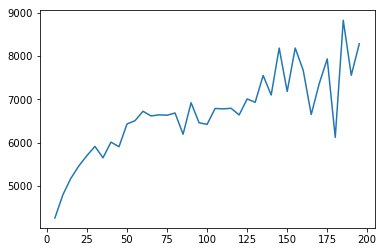

In [29]:
plt.plot(try_topic_n, [x[0] for x in scores])

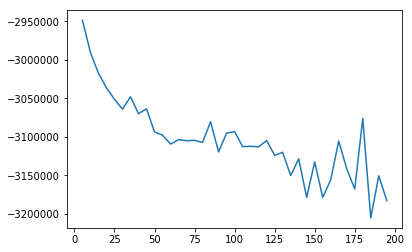

In [30]:
plt.plot(try_topic_n, [x[1] for x in scores])

In [45]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm, cv)

/Users/chench/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     31.724844        1       1  0.032337  0.028540
8      28.547969        1       2 -0.074083  0.005834
49      8.389757        1       3  0.011626 -0.009883
20      7.413525        1       4  0.091398  0.025062
14      5.964994        1       5 -0.023875 -0.023719
9       5.059119        1       6  0.119361 -0.015489
48      2.786582        1       7 -0.011181  0.015740
4       1.937910        1       8  0.025093 -0.067164
28      1.844616        1       9 -0.055809  0.036085
13      1.775684        1      10 -0.030433  0.062875
42      1.226054        1      11 -0.016790 -0.012120
32      0.920908        1      12  0.001989  0.020847
19      0.912062        1      13 -0.053968 -0.068172
35      0.448077        1      14  0.010591  0.011713
21      0.444449        1      15 -0.034116 -0.027698
25      0.442412        1      16 -0.031605  0.011752
30      0.155140        1      17  0.027058 -0.001132
10      0.000179        1      18 -0.003041  0.003113
12      0.000179        1      19 -0.000869  0.001707
7       0.000179        1      20 -0.003246 -0.003402
6       0.000179        1      21  0.001322  0.001026
5       0.000179        1      22  0.007437 -0.001492
15      0.000179        1      23 -0.015116  0.010853
3       0.000179        1      24 -0.003963 -0.001808
16      0.000179        1      25 -0.001463 -0.002789
17      0.000179        1      26  0.013940  0.000496
2       0.000179        1      27 -0.006050  0.003900
18      0.000179        1      28  0.016012  0.006222
1       0.000179        1      29  0.002646 -0.001857
24      0.000179        1      30 -0.001247  0.000078
22      0.000179        1      31 -0.003338 -0.002812
23      0.000179        1      32  0.002157 -0.001886
47      0.000179        1      33 -0.001602 -0.000759
46      0.000179        1      34 -0.000820 -0.000285
45      0.000179        1      35  0.010172 -0.010602
44      0.000179        1      36 -0.000372  0.001236
43      0.000179        1      37 -0.000623 -0.001611
41      0.000179        1      38  0.000328  0.000349
40      0.000179        1      39  0.002166  0.004981
39      0.000179        1      40  0.000002  0.002828
38      0.000179        1      41  0.006391 -0.005843
37      0.000179        1      42  0.003444 -0.000479
36      0.000179        1      43 -0.007212  0.002666
34      0.000179        1      44  0.005049  0.001840
33      0.000179        1      45 -0.003528 -0.006002
31      0.000179        1      46  0.001488  0.002969
29      0.000179        1      47 -0.003876 -0.002183
27      0.000179        1      48  0.000617  0.005847
26      0.000179        1      49 -0.003946  0.000159
0       0.000179        1      50 -0.000446  0.000473, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
4772  Default  5791.000000          ve  5791.000000  30.0000  30.0000
1272  Default  2763.000000        didn  2763.000000  29.0000  29.0000
4525  Default  3243.000000        thou  3243.000000  28.0000  28.0000
2200  Default  2280.000000      honour  2280.000000  27.0000  27.0000
4545  Default  2568.000000         thy  2568.000000  26.0000  26.0000
323   Default  2190.000000        aunt  2190.000000  25.0000  25.0000
4512  Default  2408.000000        thee  2408.000000  24.0000  24.0000
4467  Default  1990.000000         tea  1990.000000  23.0000  23.0000
4692  Default  1554.000000       uncle  1554.000000  22.0000  22.0000
1023  Default  1689.000000      cousin  1689.000000  21.0000  21.0000
2480  Default  1648.000000         isn  1648.000000  20.0000  20.0000
4989  Default  1949.000000          ye  1949.000000  19.0000  19.0000
4970  Default  1632.000000      wouldn  1632.000000  18.0000  18.0000
1008  Default  1348.000000      couldn  1348.000000  17.0000  17.0000
2703  Default  1307.000000   

### Topics

To `print` the topics, we can write a function. `display_topics` will print the most probable words to show up in each topic.

In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx, " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

Now let's print the top 10 words of the 20 topics for the model we trained, using our `display_topics` function. Have a look through the output and see what topics you can spot:

In [ ]:
display_topics(lda, dtm_feature_names, 10)

To get the probabilities for each topic for a given book we can print the whole matrix:

In [ ]:
metadata_tb['author'][25], metadata_tb['title'][25], doc_topic[25]

We can `print` which topic each novel is closest to by indexing the topic probabilities and using the `argmax` function:

In [ ]:
doc_topic = lda.transform(dtm)

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    print(metadata_tb['author'][n], metadata_tb['title'][n])
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

### Challenge

Add these topic assignments back to our `Table` `metadata_tb`

In [ ]:
# YOUR CODE HERE

### Interpreting the Model

There are many strategies that can be used to interpret the output of a topic model. In this case, we will look for any correlations between the topic distributions and metadata.

We'll first grab all the topic distributions similar to what we did above. Remember, the order is still the same!

In [ ]:
list_of_doctopics = [doc_topic[n] for n in range(len(doc_topic))]
list_of_doctopics[0]

We'll make a `DataFrame`, which is similar to a `Table`, with the probabilities for the topics (columns) and documents (rows):

In [ ]:
df = pd.DataFrame(list_of_doctopics)
df.head()

We can add these columns to our `metadata_tb` `Table`:

In [ ]:
meta = metadata_tb.to_df()
meta[df.columns] = df
meta.head()

The `corr()` method will give us a correlation matrix:

In [ ]:
meta.corr()

We see some strong correlations of topics with `date`, recall:

In [ ]:
display_topics(lda, dtm_feature_names, 10)

In [ ]:
meta.plot.scatter(x='date', y=13)

In [ ]:
meta.plot.scatter(x='date', y=1)

Why do you think we see this?

# Homework

We're going to download the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), a widely used corpus for demos of general texts:

> The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of my knowledge, it was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

First we'll import the data from `sklearn`:

In [ ]:
from sklearn.datasets import fetch_20newsgroups

We'll ask for the training data:

In [ ]:
train_subset = fetch_20newsgroups(subset="train")

Here are th predetermined catgories:

In [ ]:
train_subset.target_names

Since we're topic modeling, we don't care about what they've been labeled, but it'll be interesting to see how our topics line up with these!

How many documents are there?

In [ ]:
len(train_subset.data)

Let's get a list of documents as strings just like we did with the novels, and then we'll randomly shuffle them in case they're ordered by category already:

In [ ]:
documents_train = train_subset.data
np.random.shuffle(documents_train)

In [ ]:
print(documents_train[0])

Now we'll do the same for the test set:

In [ ]:
test_subset = fetch_20newsgroups(subset="test")
documents_test = test_subset.data
np.random.shuffle(documents_test)
print(documents_test[0])

## TASK:

You now have two arrays of strings: `documents_train` and `documents_test`. Create a `dtm` and then a topic model for `k` number of topics. Just choose one number of `k` and a low `iter` value for the training so it doesn't take too long. See how the topics match up to the annotated categories, and play with different ways of preprocessing the data. What did you have to do to get decent results?